In [1]:
import sys
import tensorflow as tf
import random
import numpy as np
tf.reset_default_graph()

def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False
    
if in_ipynb(): 
    print("In IPython")
    exec("import Tools.NanoAODConfig as Conf")
    TrainConfig="Tools/NanoAODConfig"
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")
    

{'IPKernelApp': {'connection_file': '/scratch/akapoor/.local/share/jupyter/runtime/kernel-5ae8276e-85d2-4dbf-9f10-e0e28872c836.json'}, 'InteractiveShellApp': {'extensions': <traitlets.config.loader.LazyConfigValue object at 0x7f3a352e50b8>}}
In IPython


In [2]:
if not hasattr(Conf, 'MVAlogplot'): Conf.MVAlogplot=False 
if not hasattr(Conf, 'Multicore'): Conf.Multicore=False 
if not hasattr(Conf, 'RandomState'): Conf.RandomState=42

In [3]:
tf.compat.v1.random.set_random_seed(Conf.RandomState)
random.seed(Conf.RandomState)
np.random.seed(Conf.RandomState)

import os
os.system("")
import uproot
import glob
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

Welcome to JupyROOT 6.18/00


In [4]:
from Tools.PlotTools import *
import Tools.ptetaRwt as ptetaRwt

In [5]:
if Conf.Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")

 Running in debug mode : Only every 10th event will be used


In [6]:
if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd)
prGreen("Making output directory")
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/CodeANDConfig")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/CodeANDConfig/")
os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/CodeANDConfig/")

 Making output directory


0

In [7]:
cat='EleType'
weight="NewWt"
label=["Background","Signal"]

In [8]:
#Works in uproot3
prGreen("Making data frames")
Sigdf=pd.DataFrame()
Bkgdf=pd.DataFrame()

for SigFile,SigXsecWt,SigCut in zip(Conf.SigFiles,Conf.SigXsecWts,Conf.SigCuts):
    if Conf.Debug==True:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df(branches=Conf.branches,flatten=True).query(SigCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df(branches=Conf.branches,flatten=True).query(SigCut+' & '+Conf.CommonCut)
    Sigdfi['xsecwt']=SigXsecWt
    Sigdf=pd.concat([Sigdf,Sigdfi],ignore_index=True, sort=False)
for BkgFile,BkgXsecWt,BkgCut in zip(Conf.BkgFiles,Conf.BkgXsecWts,Conf.BkgCuts):
    if Conf.Debug==True:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df(branches=Conf.branches,flatten=True).query(BkgCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df(branches=Conf.branches,flatten=True).query(BkgCut+' & '+Conf.CommonCut)
    Bkgdfi['xsecwt']=BkgXsecWt
    Bkgdf=pd.concat([Bkgdf,Bkgdfi],ignore_index=True, sort=False)
    


 Making data frames


In [9]:
Sigdf[cat]=1
Bkgdf[cat]=0

In [10]:
Bkgdf.head()

,Electron_deltaEtaSC,Electron_dr03EcalRecHitSumEt,Electron_dr03HcalDepth1TowerSumEt,Electron_dr03TkSumPt,Electron_dr03TkSumPtHEEP,Electron_dxy,Electron_dxyErr,Electron_dz,Electron_dzErr,Electron_eCorr,...,Electron_mvaFall17V2noIso_WP90,Electron_mvaFall17V2noIso_WPL,Electron_seedGain,Electron_genPartIdx,Electron_genPartFlav,Electron_cleanmask,Electron_genmatched,Electron_promptgenmatched,xsecwt,EleType
0,0.005650,0.000000,0.000000,0.0,0.0,0.003527,0.003876,0.000917,0.007263,1.009573,...,True,True,12,8,15,1,True,False,2,0
1,0.000329,0.000000,0.000000,0.0,0.0,0.004547,0.005676,0.004112,0.003906,1.011338,...,False,True,12,24,15,1,True,False,2,0
2,0.068665,2.554688,2.460938,0.0,0.0,0.009499,0.005005,0.001544,0.003021,1.005522,...,False,False,12,-1,0,1,False,False,2,0
3,0.008629,0.000000,0.000000,0.0,0.0,-0.003014,0.002014,0.045807,0.004150,1.039231,...,True,True,12,15,15,1,True,False,2,0
4,-0.023102,0.000000,0.000000,0.0,0.0,-0.016907,0.005127,0.081360,0.005493,1.012404,...,True,True,12,14,15,1,True,False,2,0


In [11]:
Sigdf["Type"]="Signal"
Bkgdf["Type"]="Background"

if Conf.Reweighing=='Nothing':
    Sigdf[weight]=Sigdf['xsecwt']
    Bkgdf[weight]=Bkgdf['xsecwt']
if Conf.Reweighing=='ptetaSig':
    Sigdf[weight],Bkgdf[weight]=ptetaRwt.ptetaRwtTested(Sigdf.copy(),Bkgdf.copy(),Conf.ptbins,Conf.etabins,'xsecwt',weight,ele_pt=Conf.ptwtvar,scl_eta=Conf.etawtvar,od=Conf.OutputDirName)
if Conf.Reweighing=='ptetaBkg':
    Bkgdf[weight],Sigdf[weight]=ptetaRwt.ptetaRwtTested(Bkgdf.copy(),Sigdf.copy(),Conf.ptbins,Conf.etabins,'xsecwt',weight,ele_pt=Conf.ptwtvar,scl_eta=Conf.etawtvar,od=Conf.OutputDirName)

df_final=pd.concat([Sigdf,Bkgdf],ignore_index=True, sort=False)
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=Conf.testsize, random_state=Conf.RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

#df_final["NewWt"]=1

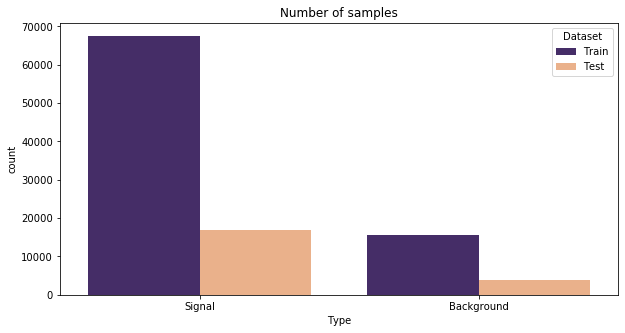

In [12]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Type", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")
    

In [13]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]
    
    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots
 XGB_1 Applying MinMaxScaler
 XGB_1 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.0s finished


 Expected neg log loss of XGB model = -37.6%
 XGB Best Parameters
 {'learning_rate': 0.1}
 Plotting output response for XGB
 Plotting ROC for XGB


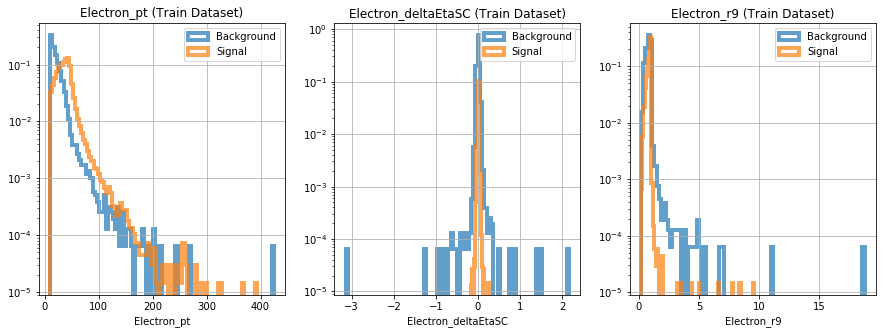

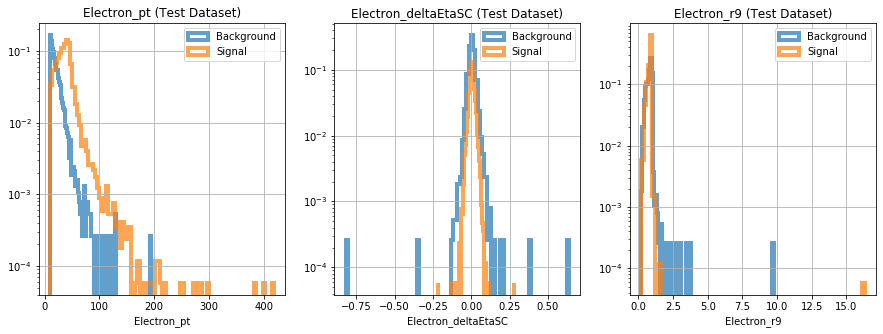

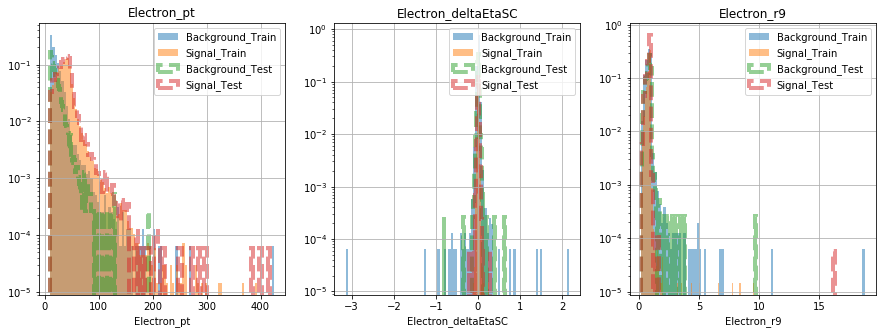

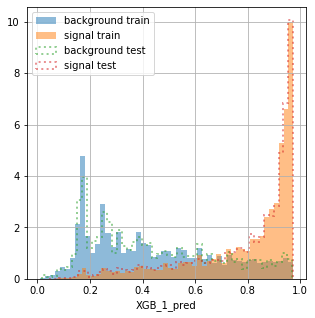

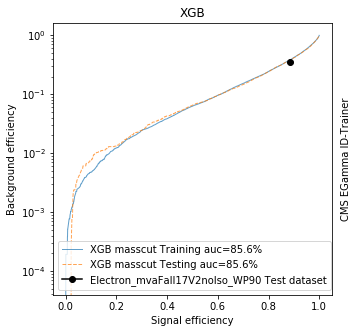

In [14]:
import pickle
import multiprocessing
for MVA in Conf.MVAs:
    
    if 'XGB' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlotsComb(df_final,Conf.features[MVA],Conf.feature_bins[MVA],MVA=MVA,OutputDirName=Conf.OutputDirName)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen(MVA+" Applying "+Conf.Scaler[MVA])
        exec("from sklearn.preprocessing import "+Conf.Scaler[MVA])
        exec("sc = "+Conf.Scaler[MVA]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen(MVA+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        #xgb_model.set_config(verbosity=2)
        prGreen("Performing XGB grid search")
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=2)#multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)
        pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelXGB.pkl", "wb"))
        #modelDNN.save(Conf.OutputDirName+"/"+MVA+"_"+"modelDNN.h5")
        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
    
        #json.dumps(search.best_params_)
        prGreen(str(search.best_params_))
    
        df_final.loc[TrainIndices,MVA+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA+"_pred"]=cv.predict_proba(X_test)[:,1]
    
        prGreen("Plotting output response for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.png")
    
        prGreen("Plotting ROC for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("XGB")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.png")

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
for MVA in Conf.MVAs:
    if 'DNN' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlotsComb(df_final,Conf.features[MVA],Conf.feature_bins[MVA],MVA=MVA,OutputDirName=Conf.OutputDirName)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen(MVA+" Applying "+Conf.Scaler[MVA])
        exec("from sklearn.preprocessing import "+Conf.Scaler[MVA])
        exec("sc = "+Conf.Scaler[MVA]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen("DNN fitting running")
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        modelDNN=Conf.DNNDict[MVA]['model']
        modelDNN.compile(loss='binary_crossentropy', optimizer=Adam(lr=Conf.DNNDict[MVA]['lr']), metrics=['accuracy',])
        train_history = modelDNN.fit(X_train,Y_train,epochs=Conf.DNNDict[MVA]['epochs'],batch_size=Conf.DNNDict[MVA]['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                     verbose=1,callbacks=[es], sample_weight=Wt_train)
        modelDNN.save(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelDNN.h5")
        df_final.loc[TrainIndices,MVA+"_pred"]=modelDNN.predict(X_train)
        df_final.loc[TestIndices,MVA+"_pred"]=modelDNN.predict(X_test)
    
        prGreen("Plotting output response for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNMVA.png")
    
        prGreen("Plotting ROC for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("DNN")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNROC.png")

In [16]:
if 'Genetic' in Conf.MVAs:
    prGreen("Sorry Genetic algo not implemented yet! Coming Soon")

 Plotting Final ROC


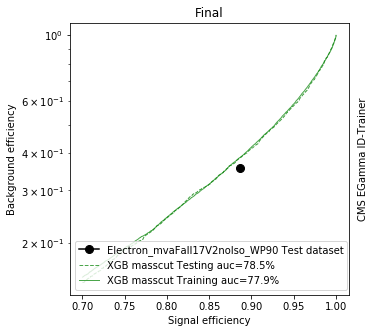

In [17]:
##PlotFinalROC
prGreen("Plotting Final ROC")
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if len(Conf.OverlayWP)>0:
    for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
        plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
if len(Conf.MVAs)>0:
    for color,MVAi in zip(Conf.MVAColors,Conf.MVAs):
        plot_roc_curve(df_final.query('TrainDataset==0'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='--', label=Conf.MVALabels[MVAi]+' Testing',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==1'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='-', label=Conf.MVALabels[MVAi]+' Training',cat=cat,Wt=weight)
    axes.set_ylabel("Background efficiency")
    axes.set_xlabel("Signal efficiency")
    axes.set_title("Final")
    axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        transform=axes.transAxes)
plt.savefig(Conf.OutputDirName+"/ROCFinal.pdf")
plt.savefig(Conf.OutputDirName+"/ROCFinal.png")

In [18]:
PredMVAs=[]
for MVA in Conf.MVAs:
    PredMVAs.append(MVA+'_pred')
SigEffWPs=Conf.SigEffWPs[:]
for i,SigEffWPi in enumerate(SigEffWPs):
    SigEffWPs[i]=int(SigEffWPi.replace('%', ''))/100

if len(Conf.MVAs)>0:
    prGreen("Threshold values for requested Signal Efficiencies (Train Dataset)")
    mydf=df_final.query("TrainDataset==1 & EleType==1")[PredMVAs].quantile(SigEffWPs)
    mydf.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf.set_index("WPs",inplace=True)
    prGreen(mydf)
    mydf.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.html")
    mydf.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.csv")
    prGreen("Threshold values for requested Signal Efficiencies (Test Dataset)")
    mydf2=df_final.query("TrainDataset==0 & EleType==1")[PredMVAs].quantile(SigEffWPs)
    mydf2.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf2.set_index("WPs",inplace=True)
    prGreen(mydf2)
    mydf2.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.html")
    mydf2.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.csv")

 Threshold values for requested Signal Efficiencies (Train Dataset)
      XGB_1_pred
WPs            
80%    0.953868
90%    0.965674
 Threshold values for requested Signal Efficiencies (Test Dataset)
      XGB_1_pred
WPs            
80%    0.953944
90%    0.966070


In [19]:
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*ROC*png',Conf.OutputDirName+'/*ROC*png'],Save=Conf.OutputDirName+"/mydocROC.pdf")
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*MVA*png'],Save=Conf.OutputDirName+"/mydocMVA.pdf")

prGreen("Done!! Please find the quick look ROC pdf here "+Conf.OutputDirName+"/mydocROC.pdf")
prGreen("Done!! Please find the quick look MVA pdf here "+Conf.OutputDirName+"/mydocMVA.pdf")
prGreen("Individual plots and saved model files can be found in directory: "+Conf.OutputDirName+'/')

 Done!! Please find the quick look ROC pdf here Output/mydocROC.pdf
 Done!! Please find the quick look MVA pdf here Output/mydocMVA.pdf
 Individual plots and saved model files can be found in directory: Output/


In [20]:
if hasattr(Conf, 'SaveDataFrameCSV'): 
    if Conf.SaveDataFrameCSV:
        prGreen("Saving DataFrame : Can take a lot of time")
        os.system("mkdir -p " + Conf.OutputDirName+"/DataFrame")    
        df_final.to_csv(Conf.OutputDirName+'/DataFrame/df_final.csv')